In [142]:
from importlib import reload  # Python 3.4+
import simtoolkit.simtoolkit as sim
sim = reload(sim)
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 9) #if your plots turn out too large or small, adjust this


In [143]:
larmor_frequency = 64.0e6 #Hz
offset_frequency = 4.7e-6 * larmor_frequency
stdev_offset = 0.3e-6 * larmor_frequency
stdev_larmor = 0.2e-6 #ppm

number_spins = 1000
timepoints = range(0,1000,5)
spins = sim.Spinensemble(number_spins, offset_frequency, stdev_offset)

In [144]:
v = sim.Vector(3,1,1)
v.negative()
v = v.negative()
print(f"{v.toString()}")

s = sim.Spin(larmor_frequency, 1.0)
s.rotatex(np.deg2rad(180))
print(f"{s.toString()}")
for i in range(10):
    s.relax(10)
    print(f"{s.toString()}")


(-3, -1, -1)
Frequency = 64000000.0, vector = (0.0, -1.2246467991473532e-16, -1.0), magnitude = 1.0
Frequency = 64000000.0, vector = (0.0, -9.797174393178826e-17, -0.6), magnitude = 1.0
Frequency = 64000000.0, vector = (0.0, -7.83773951454306e-17, -0.2799999999999999), magnitude = 1.0
Frequency = 64000000.0, vector = (0.0, -6.270191611634448e-17, -0.023999999999999966), magnitude = 1.0
Frequency = 64000000.0, vector = (0.0, -5.0161532893075584e-17, 0.18080000000000004), magnitude = 1.0
Frequency = 64000000.0, vector = (0.0, -4.0129226314460464e-17, 0.34464000000000006), magnitude = 1.0
Frequency = 64000000.0, vector = (0.0, -3.210338105156837e-17, 0.475712), magnitude = 1.0
Frequency = 64000000.0, vector = (0.0, -2.5682704841254696e-17, 0.5805696), magnitude = 1.0
Frequency = 64000000.0, vector = (0.0, -2.0546163873003756e-17, 0.66445568), magnitude = 1.0
Frequency = 64000000.0, vector = (0.0, -1.6436931098403003e-17, 0.731564544), magnitude = 1.0
Frequency = 64000000.0, vector = (0.0,

In [145]:
signal = signal_over_time
signal[1]
# mag_signal = [a[0] for a in signal[1]]
# max_mag_signal = max(mag_signal)
# xy_signal = [a[1] for a in signal[1]]
# z_signal = [a[2] for a in signal[1]]
# for i in range(100):
#     z_signal[i].print()

[[2000.0, 0.0, 2000.0],
 [1900.0000000000334, 0.0, 1900.0000000000334],
 [1809.9999999999616, 0.0, 1809.9999999999616],
 [1729.0000000000282, 0.0, 1729.0000000000282],
 [1656.0999999999801, 0.0, 1656.0999999999801],
 [1590.490000000028, 0.0, 1590.490000000028],
 [1531.441000000015, 0.0, 1531.441000000015],
 [1478.296900000017, 0.0, 1478.296900000017],
 [1430.4672099999773, 0.0, 1430.4672099999773],
 [1387.4204890000105, 0.0, 1387.4204890000105],
 [1348.678440100002, 0.0, 1348.678440100002],
 [1313.8105960899838, 0.0, 1313.8105960899838],
 [1282.4295364810037, 0.0, 1282.4295364810037],
 [1254.186582832898, 0.0, 1254.186582832898],
 [1228.7679245496245, 0.0, 1228.7679245496245],
 [1205.891132094627, 0.0, 1205.891132094627],
 [1185.3020188851972, 0.0, 1185.3020188851972],
 [1166.7718169966631, 0.0, 1166.7718169966631],
 [1150.0946352970047, 0.0, 1150.0946352970047],
 [1135.0851717672883, 0.0, 1135.0851717672883],
 [1121.5766545905483, 1.3735352600427532e-13, -1121.5766545905483],
 [909.41

  0%|          | 0/199 [00:00<?, ?it/s]

  8%|▊         | 16/199 [00:00<00:04, 42.14it/s]

pulse.time=50, timepoints=[46, 47, 48, 49, 50]
applying x-pulse(50, 90)


 13%|█▎        | 26/199 [00:00<00:04, 37.93it/s]

pulse.time=100, timepoints=[96, 97, 98, 99, 100]
applying invert(100)


 32%|███▏      | 64/199 [00:01<00:03, 36.17it/s]

pulse.time=300, timepoints=[296, 297, 298, 299, 300]
applying invert(300)


100%|██████████| 199/199 [00:05<00:00, 37.10it/s]


[1999.9982764016286, 1999.998448761513, 1999.9986038853738, 1999.9987434968589, 1999.9988691470783, 1999.9989822324433, 1999.9990840091884, 1999.9991756082945, 1999.999258047413, 1999.9993322426674, 1999.9993990184075, 1505.9545354055417, 854.2935828398122, 602.6951947267906, 690.0352781888843, 819.7012377326369, 937.792326563937, 1043.8817731087222, 1139.3230140704766, 1225.2464824487563, 1302.6634502334218, 972.4511077825149, 675.3278873126288, 407.970577390894, 167.56468165734842, 51.166211213338975, 245.34121624352943, 424.659020525944, 595.4459734542595, 754.5160812088121, 882.5945638680979, 980.5339279395616, 1071.2822883261786, 1160.954797315305, 1244.4794779977892, 1320.0213193644986, 1388.0202939691283, 1449.2172681961085, 1504.2938670058218, 1553.8629061885408, 1598.4759430774511, 1638.6291686993936, 1674.7658935760126, 1707.2895583973054, 1736.5610804723626, 1762.904572039953, 1786.6143442302166, 1807.9538103296768, 1827.1581030474272, 1844.4413940938457, 1859.997197223825, 

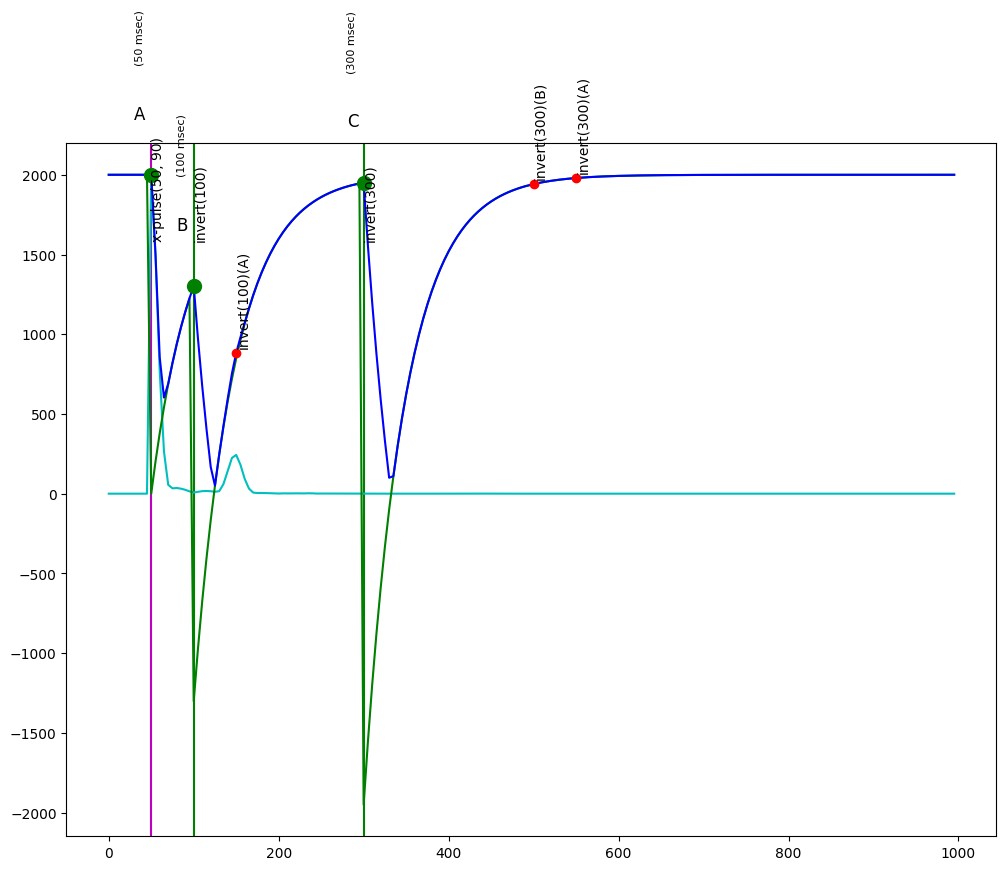

In [148]:
pulseSequence = sim.PulseSequence()
# pulseSequence.add(sim.Pulse("x-pulse", 50, 90))
# pulseSequence.add(sim.Pulse("invert", 100, None))
# pulseSequence.add(sim.Pulse("invert", 300, None))

pulseSequence.add(Pulse("x-pulse", 50, 70))
pulseSequence.add(Pulse("x-pulse", 100, 70))
pulseSequence.add(Pulse("x-pulse", 300, 70))

signal_over_time = pulseSequence.simulate(spins, timepoints)

pulseSequence.plotWithSignal(signal_over_time)

pulseSequence.determineHeightOfExpectedPeaks()
print(pulseSequence.expected_peaks)
print(signal_over_time[2]) #peaks
pulseSequence.showPeakLabels()
pulseSequence.showExpectedPeaks()